# Lab 3
## Convolutional Neural Networks (CNNs)


In [1]:
%matplotlib inline

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, initializers, optimizers

### Initialisations

Let us write some helper functions to initialise weights and biases. We'll initialise weights as Gaussian random variables with mean 0 and variance 0.0025. For biases we'll initialise everything with a constant 0.1. This is because we're mainly going to be using ReLU non-linearities.

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

We'll also initialize the MNIST data set for training and testing.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
def one_hot(labels):
  return tf.one_hot(labels, len(np.unique(labels)))

In [5]:
train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

### Visualization
Let us visualise the first 16 data points from the MNIST training data

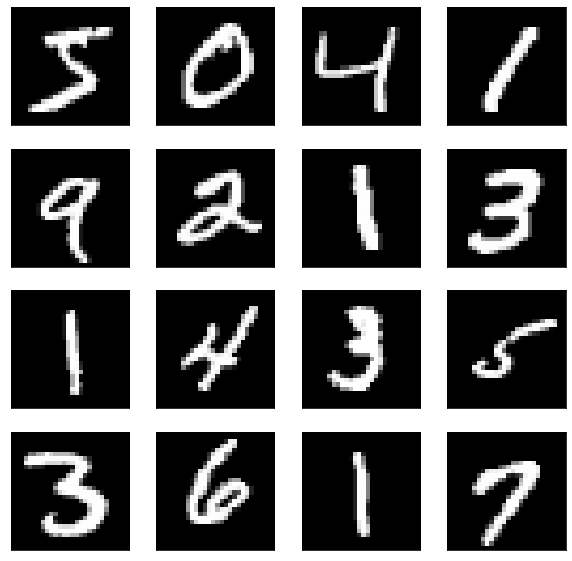

In [6]:
fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(train_images[i].reshape(28, 28), cmap='Greys_r')  

### Model

Let's define the model. The model is defined as follows:

* An input that is 728 dimensional vector. 
* Reshape the input as 28x28x1 images (only 1 because they are grey scale) 
* A convolutional layer with 25 filters of shape 12x12x1 and a ReLU non-linearity (with stride (2, 2) and no padding)
* A convolutional layer with 64 filters of shape 5x5x25 and a ReLU non-linearity (with stride (1, 2) and padding to maintain size)
* A max_pooling layer of shape 2x2
* A fully connected layer taking all the outputs of the max_pooling layer to 1024 units and ReLU nonlinearity
* A fully connected layer taking 1024 units to 10 no activation function (the softmax non-linearity will be included in the loss function rather than in the model)

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(
    filters=25,
    kernel_size=(12, 12),
    strides=(2,2),
    activation='relu',
    input_shape=(28, 28, 1),
    padding='valid',  # uses no padding
    kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.05),
    use_bias=True,
    bias_initializer=initializers.Constant(0.1)
))
model.add(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1,1),
    activation='relu',
    padding='same'  # pads to maintain width and height
))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(
    units=1024,
    activation='relu'
))
model.add(layers.Dropout(
    rate=0.2
))
model.add(layers.Dense(
    units=10,
    activation='softmax'
))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 25)          3625      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          40064     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [8]:
# Visualize the flow of data through the model

# tf.keras.utils.plot_model(model, show_shapes=True)

Now that the model sequence has been defined, we can train our model on the provided training data. The model fitting has been specified so that it uses 5000 iterations of batches of size 50 — this is separated into 50 epochs, with 100 iterations each.

In [9]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0, 
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
    ),
    metrics=['accuracy']
)

history = model.fit(
    train_images.reshape(60000, 28, 28, 1),
    train_labels,
    batch_size=50,
    steps_per_epoch=100,
    epochs=50, 
    validation_data=(test_images.reshape(10000, 28, 28, 1), test_labels)
)

Epoch 1/50
100/100 [==============================] - 10s 98ms/step - loss: 1.8155 - accuracy: 0.4945 - val_loss: 0.5455 - val_accuracy: 0.8531
Epoch 2/50
100/100 [==============================] - 10s 100ms/step - loss: 0.5701 - accuracy: 0.8307 - val_loss: 0.3719 - val_accuracy: 0.8884
Epoch 3/50
100/100 [==============================] - 9s 94ms/step - loss: 0.3921 - accuracy: 0.8824 - val_loss: 0.3245 - val_accuracy: 0.9011
Epoch 4/50
100/100 [==============================] - 9s 87ms/step - loss: 0.3319 - accuracy: 0.9007 - val_loss: 0.2581 - val_accuracy: 0.9268
Epoch 5/50
100/100 [==============================] - 9s 91ms/step - loss: 0.3249 - accuracy: 0.9103 - val_loss: 0.2216 - val_accuracy: 0.9382
Epoch 6/50
100/100 [==============================] - 9s 91ms/step - loss: 0.2472 - accuracy: 0.9277 - val_loss: 0.2139 - val_accuracy: 0.9364
Epoch 7/50
100/100 [==============================] - 10s 97ms/step - loss: 0.2157 - accuracy: 0.9371 - val_loss: 0.1694 - val_accuracy: 0.

313/313 - 1s - loss: 0.0583 - accuracy: 0.1090


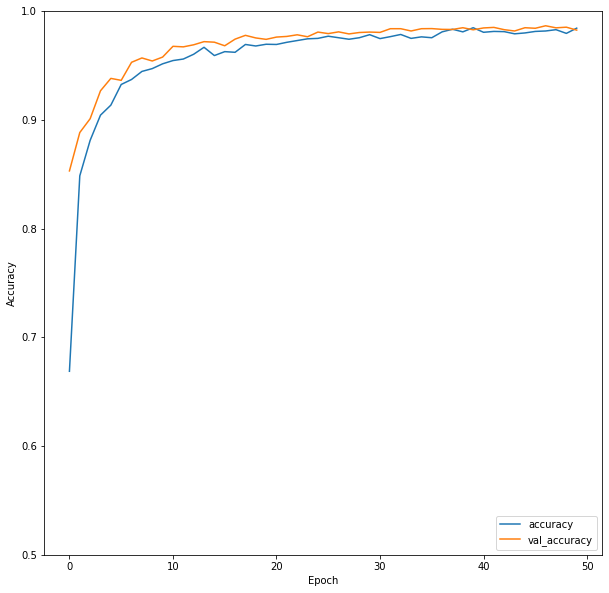

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images.reshape(10000, 28, 28, 1),  test_labels, verbose=2)

With minibatches of size 50 and 5000 iterations (50 epochs of 100 iterations each), the accuracy with this model is 0.9891999959945679!

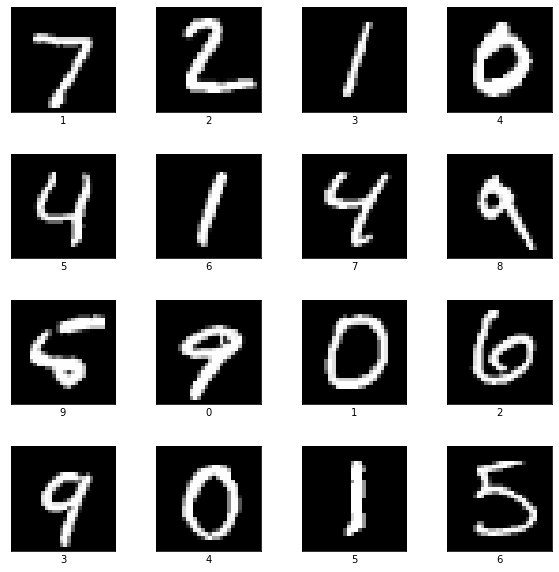

In [15]:
def visualize_prediction(image_data):
  assert(len(image_data) >= 16)
  predictions = list(map(np.argmax, model.predict(image_data[:16].reshape(16, 28, 28, 1))))

  fig = plt.figure()
  for i in range(16):
      ax = fig.add_subplot(4, 4, i + 1)
      ax.set_xticks(())
      ax.set_yticks(())
      ax.imshow(image_data[i].reshape(28, 28), cmap='Greys_r')
      ax.set_xlabel(predictions[i])

  fig.subplots_adjust(hspace=0.4)

visualize_prediction(test_images[:16])

### Unused Skeleton Code
The code below was provided for TensorFlow users. I have not touched this code, since I found the Keras submodule of TensorFlow to be easier to use.

In [12]:
x = tf.placeholder(tf.float32, shape=[None, 784])
x_ = tf.reshape(x, [-1, 28, 28, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Define the first convolution layer here
# TODO
# W_conv1 =
# b_conv1 = 
# h_conv1 = 

# Define the second convolution layer here
# W_conv2 = 
# b_conv2 = 
# h_conv2 = 

# Define maxpooling
# h_pool2 = 

# All subsequent layers will be fully connected ignoring geometry so we'll flatten the layer
# Flatten the h_pool2_layer (as it has a multidimensiona shape) 
# h_pool2_flat = 

# Define the first fully connected layer here
# W_fc1 = 
# b_fc1 = 
# h_fc1 = 

# Use dropout for this layer (should you wish)
# keep_prob = tf.placeholder(tf.float32)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# The final fully connected layer
# W_fc2 = 
# b_fc2 = 
# y_conv = 

AttributeError: module 'tensorflow' has no attribute 'placeholder'

#### Loss Function, Accuracy and Training Algorithm

* We'll use the cross entropy loss function. The loss function is called `tf.nn.cross_entropy_with_logits` in tensorflow.

* Accuray is simply defined as the fraction of data correctly classified.

* For training you should use the AdamOptimizer (read the documentation) and set the learning rate to be 1e-4. You are welcome, and in fact encouraged, to experiment with other optimisation procedures and learning rates. 

* (Optional): You may even want to use different filter sizes once you are finished with experimenting with what is asked in this practical

In [ ]:
# We'll use the cross entropy loss function 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# And classification accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# And the Adam optimiser
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [ ]:
# Load the mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [ ]:
# Let us visualise the first 16 data points from the MNIST training data

fig = plt.figure()
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap='Greys_r')  

In [ ]:
# Start a tf session and run the optimisation algorithm
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(3000):
    batch = mnist.train.next_batch(50)
    # TODO
    # Write the optimisation code here

In [ ]:
# Print accuracy on the test set
# print ('Test accuracy: %g' % sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

#### Visualising the Filters

We'll now visualise all the 32 filters in the first convolution layer. As they are each of shape 12x12x1, they may themselves be viewed as greyscale images. Visualising filters in further layers is more complicated and involves modifying the neural network. See the paper (https://arxiv.org/pdf/1311.2901.pdf) by Matt Zeiler and Rob Fergus if you are interested. 

In [ ]:
# Visualise the filters in the first convolutional layer
with sess.as_default():
    W = W_conv1.eval()

# Add code to visualise filters here

#### Identifying image patches that activate the filters

For this part you'll find the 12 patches in the test-set that activate each of the first 5 filters that maximise the activation for that filter.

In [ ]:
H =  sess.run(h_conv1, feed_dict={x: mnist.test.images})


# Add code to visualise patches in the test set that find the most result in 
# the highest activations for filters 0, ... 4